# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 5, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=5, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 5, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.4964
Epoch 1/200, Iteration 2/12, Loss: 1.2851
Epoch 1/200, Iteration 3/12, Loss: 1.0974
Epoch 1/200, Iteration 4/12, Loss: 1.0367
Epoch 1/200, Iteration 5/12, Loss: 0.9174
Epoch 1/200, Iteration 6/12, Loss: 1.1831
Epoch 1/200, Iteration 7/12, Loss: 1.2535
Epoch 1/200, Iteration 8/12, Loss: 1.1395
Epoch 1/200, Iteration 9/12, Loss: 0.9676
Epoch 1/200, Iteration 10/12, Loss: 1.0316
Epoch 1/200, Iteration 11/12, Loss: 0.9466
Epoch 1/200, Iteration 12/12, Loss: 0.9211
Epoch 1/200, Iteration 13/12, Loss: 0.7910
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.904231, MRE: 0.582817, MAE: 0.098606 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.843587, MRE: 0.465767, MAE: 0.088229 

Epoch 2/200, Iteration 1/12, Loss: 1.0317
Epoch 2/200, Iteration 2/12, Loss: 0.9263
Epoch 2/200, Iteration 3/12, Loss: 0.9762
Epoch 2/200, Iteration 4/12, Loss: 0.7203
Epoch 2/200, Iteration 5/12, Loss: 0.7432
Epoch 2/200, Iteration 6/12, Loss: 0.7130
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 71.38%, Avg loss: 0.056052, MRE: 0.143688, MAE: 0.019672 

Test Error: 
 Accuracy: 68.5%, Avg loss: 0.052134, MRE: 0.132585, MAE: 0.019841 

Epoch 13/200, Iteration 1/12, Loss: 0.0477
Epoch 13/200, Iteration 2/12, Loss: 0.0635
Epoch 13/200, Iteration 3/12, Loss: 0.0549
Epoch 13/200, Iteration 4/12, Loss: 0.0332
Epoch 13/200, Iteration 5/12, Loss: 0.0574
Epoch 13/200, Iteration 6/12, Loss: 0.0723
Epoch 13/200, Iteration 7/12, Loss: 0.0730
Epoch 13/200, Iteration 8/12, Loss: 0.0380
Epoch 13/200, Iteration 9/12, Loss: 0.0407
Epoch 13/200, Iteration 10/12, Loss: 0.0678
Epoch 13/200, Iteration 11/12, Loss: 0.0478
Epoch 13/200, Iteration 12/12, Loss: 0.0500
Epoch 13/200, Iteration 13/12, Loss: 0.0637
Train Error: 
 Accuracy: 69.25%, Avg loss: 0.051356, MRE: 0.125645, MAE: 0.018305 

Test Error: 
 Accuracy: 68.0%, Avg loss: 0.042972, MRE: 0.116759, MAE: 0.017926 

Epoch 14/200, Iteration 1/12, Loss: 0.0602
Epoch 14/200, Iteration 2/12, Loss: 0.0574
Epoch 14/200, Itera

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.027643, MRE: 0.080233, MAE: 0.014988 

Epoch 25/200, Iteration 1/12, Loss: 0.0290
Epoch 25/200, Iteration 2/12, Loss: 0.0161
Epoch 25/200, Iteration 3/12, Loss: 0.0392
Epoch 25/200, Iteration 4/12, Loss: 0.0345
Epoch 25/200, Iteration 5/12, Loss: 0.0462
Epoch 25/200, Iteration 6/12, Loss: 0.0433
Epoch 25/200, Iteration 7/12, Loss: 0.0519
Epoch 25/200, Iteration 8/12, Loss: 0.0227
Epoch 25/200, Iteration 9/12, Loss: 0.0411
Epoch 25/200, Iteration 10/12, Loss: 0.0301
Epoch 25/200, Iteration 11/12, Loss: 0.0574
Epoch 25/200, Iteration 12/12, Loss: 0.0318
Epoch 25/200, Iteration 13/12, Loss: 0.0224
Train Error: 
 Accuracy: 75.62%, Avg loss: 0.037050, MRE: 0.085047, MAE: 0.014682 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.029648, MRE: 0.082299, MAE: 0.015199 

Epoch 26/200, Iteration 1/12, Loss: 0.0384
Epoch 26/200, Iteration 2/12, Loss: 0.0205
Epoch 26/200, Iteration 3/12, Loss: 0.0388
Epoch 26/200, Iteration 4/12, Loss: 0.0303
Epoch 26/200, Ite

Train Error: 
 Accuracy: 78.38%, Avg loss: 0.030192, MRE: 0.075911, MAE: 0.012246 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.022645, MRE: 0.070636, MAE: 0.012375 

Epoch 37/200, Iteration 1/12, Loss: 0.0323
Epoch 37/200, Iteration 2/12, Loss: 0.0388
Epoch 37/200, Iteration 3/12, Loss: 0.0176
Epoch 37/200, Iteration 4/12, Loss: 0.0412
Epoch 37/200, Iteration 5/12, Loss: 0.0333
Epoch 37/200, Iteration 6/12, Loss: 0.0441
Epoch 37/200, Iteration 7/12, Loss: 0.0289
Epoch 37/200, Iteration 8/12, Loss: 0.0342
Epoch 37/200, Iteration 9/12, Loss: 0.0434
Epoch 37/200, Iteration 10/12, Loss: 0.0328
Epoch 37/200, Iteration 11/12, Loss: 0.0486
Epoch 37/200, Iteration 12/12, Loss: 0.0187
Epoch 37/200, Iteration 13/12, Loss: 0.0409
Train Error: 
 Accuracy: 69.5%, Avg loss: 0.031220, MRE: 0.077563, MAE: 0.012933 

Test Error: 
 Accuracy: 65.5%, Avg loss: 0.022046, MRE: 0.072518, MAE: 0.012130 

Epoch 38/200, Iteration 1/12, Loss: 0.0311
Epoch 38/200, Iteration 2/12, Loss: 0.0458
Epoch 38/200, Iterat

Epoch 48/200, Iteration 4/12, Loss: 0.0253
Epoch 48/200, Iteration 5/12, Loss: 0.0132
Epoch 48/200, Iteration 6/12, Loss: 0.0381
Epoch 48/200, Iteration 7/12, Loss: 0.0138
Epoch 48/200, Iteration 8/12, Loss: 0.0283
Epoch 48/200, Iteration 9/12, Loss: 0.0407
Epoch 48/200, Iteration 10/12, Loss: 0.0218
Epoch 48/200, Iteration 11/12, Loss: 0.0187
Epoch 48/200, Iteration 12/12, Loss: 0.0146
Epoch 48/200, Iteration 13/12, Loss: 0.0367
Train Error: 
 Accuracy: 78.12%, Avg loss: 0.023327, MRE: 0.073555, MAE: 0.011575 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.022782, MRE: 0.068379, MAE: 0.012146 

Epoch 49/200, Iteration 1/12, Loss: 0.0183
Epoch 49/200, Iteration 2/12, Loss: 0.0227
Epoch 49/200, Iteration 3/12, Loss: 0.0216
Epoch 49/200, Iteration 4/12, Loss: 0.0123
Epoch 49/200, Iteration 5/12, Loss: 0.0194
Epoch 49/200, Iteration 6/12, Loss: 0.0222
Epoch 49/200, Iteration 7/12, Loss: 0.0293
Epoch 49/200, Iteration 8/12, Loss: 0.0215
Epoch 49/200, Iteration 9/12, Loss: 0.0165
Epoch 49/200,

Train Error: 
 Accuracy: 75.5%, Avg loss: 0.018370, MRE: 0.072302, MAE: 0.010503 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.015909, MRE: 0.061314, MAE: 0.009920 

Epoch 60/200, Iteration 1/12, Loss: 0.0096
Epoch 60/200, Iteration 2/12, Loss: 0.0204
Epoch 60/200, Iteration 3/12, Loss: 0.0215
Epoch 60/200, Iteration 4/12, Loss: 0.0181
Epoch 60/200, Iteration 5/12, Loss: 0.0128
Epoch 60/200, Iteration 6/12, Loss: 0.0129
Epoch 60/200, Iteration 7/12, Loss: 0.0141
Epoch 60/200, Iteration 8/12, Loss: 0.0172
Epoch 60/200, Iteration 9/12, Loss: 0.0135
Epoch 60/200, Iteration 10/12, Loss: 0.0269
Epoch 60/200, Iteration 11/12, Loss: 0.0285
Epoch 60/200, Iteration 12/12, Loss: 0.0216
Epoch 60/200, Iteration 13/12, Loss: 0.0295
Train Error: 
 Accuracy: 85.25%, Avg loss: 0.018477, MRE: 0.072244, MAE: 0.010257 

Test Error: 
 Accuracy: 80.5%, Avg loss: 0.016386, MRE: 0.060398, MAE: 0.009696 

Epoch 61/200, Iteration 1/12, Loss: 0.0144
Epoch 61/200, Iteration 2/12, Loss: 0.0201
Epoch 61/200, Iterat

Train Error: 
 Accuracy: 84.5%, Avg loss: 0.014434, MRE: 0.067367, MAE: 0.009262 

Test Error: 
 Accuracy: 80.5%, Avg loss: 0.013112, MRE: 0.057454, MAE: 0.008980 

Epoch 72/200, Iteration 1/12, Loss: 0.0100
Epoch 72/200, Iteration 2/12, Loss: 0.0124
Epoch 72/200, Iteration 3/12, Loss: 0.0124
Epoch 72/200, Iteration 4/12, Loss: 0.0223
Epoch 72/200, Iteration 5/12, Loss: 0.0122
Epoch 72/200, Iteration 6/12, Loss: 0.0158
Epoch 72/200, Iteration 7/12, Loss: 0.0128
Epoch 72/200, Iteration 8/12, Loss: 0.0183
Epoch 72/200, Iteration 9/12, Loss: 0.0175
Epoch 72/200, Iteration 10/12, Loss: 0.0144
Epoch 72/200, Iteration 11/12, Loss: 0.0286
Epoch 72/200, Iteration 12/12, Loss: 0.0110
Epoch 72/200, Iteration 13/12, Loss: 0.0218
Train Error: 
 Accuracy: 85.62%, Avg loss: 0.013819, MRE: 0.067272, MAE: 0.009106 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.013456, MRE: 0.057869, MAE: 0.008983 

Epoch 73/200, Iteration 1/12, Loss: 0.0140
Epoch 73/200, Iteration 2/12, Loss: 0.0109
Epoch 73/200, Iterat

Train Error: 
 Accuracy: 82.5%, Avg loss: 0.011979, MRE: 0.061044, MAE: 0.008889 

Test Error: 
 Accuracy: 79.0%, Avg loss: 0.010845, MRE: 0.054174, MAE: 0.008844 

Epoch 84/200, Iteration 1/12, Loss: 0.0085
Epoch 84/200, Iteration 2/12, Loss: 0.0102
Epoch 84/200, Iteration 3/12, Loss: 0.0132
Epoch 84/200, Iteration 4/12, Loss: 0.0167
Epoch 84/200, Iteration 5/12, Loss: 0.0111
Epoch 84/200, Iteration 6/12, Loss: 0.0105
Epoch 84/200, Iteration 7/12, Loss: 0.0074
Epoch 84/200, Iteration 8/12, Loss: 0.0077
Epoch 84/200, Iteration 9/12, Loss: 0.0133
Epoch 84/200, Iteration 10/12, Loss: 0.0120
Epoch 84/200, Iteration 11/12, Loss: 0.0148
Epoch 84/200, Iteration 12/12, Loss: 0.0134
Epoch 84/200, Iteration 13/12, Loss: 0.0156
Train Error: 
 Accuracy: 87.38%, Avg loss: 0.011358, MRE: 0.060907, MAE: 0.008234 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.011295, MRE: 0.053418, MAE: 0.008305 

Epoch 85/200, Iteration 1/12, Loss: 0.0170
Epoch 85/200, Iteration 2/12, Loss: 0.0068
Epoch 85/200, Iterat

Train Error: 
 Accuracy: 84.62%, Avg loss: 0.009644, MRE: 0.054545, MAE: 0.007840 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.009166, MRE: 0.051187, MAE: 0.008103 

Epoch 97/200, Iteration 1/12, Loss: 0.0065
Epoch 97/200, Iteration 2/12, Loss: 0.0097
Epoch 97/200, Iteration 3/12, Loss: 0.0086
Epoch 97/200, Iteration 4/12, Loss: 0.0128
Epoch 97/200, Iteration 5/12, Loss: 0.0085
Epoch 97/200, Iteration 6/12, Loss: 0.0119
Epoch 97/200, Iteration 7/12, Loss: 0.0083
Epoch 97/200, Iteration 8/12, Loss: 0.0122
Epoch 97/200, Iteration 9/12, Loss: 0.0109
Epoch 97/200, Iteration 10/12, Loss: 0.0095
Epoch 97/200, Iteration 11/12, Loss: 0.0080
Epoch 97/200, Iteration 12/12, Loss: 0.0140
Epoch 97/200, Iteration 13/12, Loss: 0.0060
Train Error: 
 Accuracy: 86.88%, Avg loss: 0.009412, MRE: 0.053720, MAE: 0.007843 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.009221, MRE: 0.050788, MAE: 0.008105 

Epoch 98/200, Iteration 1/12, Loss: 0.0110
Epoch 98/200, Iteration 2/12, Loss: 0.0087
Epoch 98/200, Itera

Epoch 109/200, Iteration 4/12, Loss: 0.0113
Epoch 109/200, Iteration 5/12, Loss: 0.0095
Epoch 109/200, Iteration 6/12, Loss: 0.0107
Epoch 109/200, Iteration 7/12, Loss: 0.0085
Epoch 109/200, Iteration 8/12, Loss: 0.0103
Epoch 109/200, Iteration 9/12, Loss: 0.0060
Epoch 109/200, Iteration 10/12, Loss: 0.0077
Epoch 109/200, Iteration 11/12, Loss: 0.0097
Epoch 109/200, Iteration 12/12, Loss: 0.0092
Epoch 109/200, Iteration 13/12, Loss: 0.0048
Train Error: 
 Accuracy: 84.62%, Avg loss: 0.008536, MRE: 0.050947, MAE: 0.007427 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.008312, MRE: 0.049171, MAE: 0.007509 

Epoch 110/200, Iteration 1/12, Loss: 0.0054
Epoch 110/200, Iteration 2/12, Loss: 0.0094
Epoch 110/200, Iteration 3/12, Loss: 0.0067
Epoch 110/200, Iteration 4/12, Loss: 0.0097
Epoch 110/200, Iteration 5/12, Loss: 0.0134
Epoch 110/200, Iteration 6/12, Loss: 0.0103
Epoch 110/200, Iteration 7/12, Loss: 0.0087
Epoch 110/200, Iteration 8/12, Loss: 0.0110
Epoch 110/200, Iteration 9/12, Loss: 0

Train Error: 
 Accuracy: 85.38%, Avg loss: 0.008003, MRE: 0.050882, MAE: 0.007499 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.007694, MRE: 0.048138, MAE: 0.007517 

Epoch 121/200, Iteration 1/12, Loss: 0.0063
Epoch 121/200, Iteration 2/12, Loss: 0.0099
Epoch 121/200, Iteration 3/12, Loss: 0.0078
Epoch 121/200, Iteration 4/12, Loss: 0.0113
Epoch 121/200, Iteration 5/12, Loss: 0.0088
Epoch 121/200, Iteration 6/12, Loss: 0.0097
Epoch 121/200, Iteration 7/12, Loss: 0.0084
Epoch 121/200, Iteration 8/12, Loss: 0.0088
Epoch 121/200, Iteration 9/12, Loss: 0.0056
Epoch 121/200, Iteration 10/12, Loss: 0.0063
Epoch 121/200, Iteration 11/12, Loss: 0.0117
Epoch 121/200, Iteration 12/12, Loss: 0.0073
Epoch 121/200, Iteration 13/12, Loss: 0.0067
Train Error: 
 Accuracy: 84.62%, Avg loss: 0.008167, MRE: 0.051272, MAE: 0.007593 

Test Error: 
 Accuracy: 80.5%, Avg loss: 0.008046, MRE: 0.050681, MAE: 0.007950 

Epoch 122/200, Iteration 1/12, Loss: 0.0080
Epoch 122/200, Iteration 2/12, Loss: 0.0119
Epoc

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.006872, MRE: 0.047514, MAE: 0.007378 

Epoch 133/200, Iteration 1/12, Loss: 0.0074
Epoch 133/200, Iteration 2/12, Loss: 0.0073
Epoch 133/200, Iteration 3/12, Loss: 0.0071
Epoch 133/200, Iteration 4/12, Loss: 0.0084
Epoch 133/200, Iteration 5/12, Loss: 0.0079
Epoch 133/200, Iteration 6/12, Loss: 0.0080
Epoch 133/200, Iteration 7/12, Loss: 0.0062
Epoch 133/200, Iteration 8/12, Loss: 0.0080
Epoch 133/200, Iteration 9/12, Loss: 0.0074
Epoch 133/200, Iteration 10/12, Loss: 0.0070
Epoch 133/200, Iteration 11/12, Loss: 0.0078
Epoch 133/200, Iteration 12/12, Loss: 0.0057
Epoch 133/200, Iteration 13/12, Loss: 0.0067
Train Error: 
 Accuracy: 86.25%, Avg loss: 0.007241, MRE: 0.050846, MAE: 0.007320 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.007208, MRE: 0.048938, MAE: 0.007450 

Epoch 134/200, Iteration 1/12, Loss: 0.0073
Epoch 134/200, Iteration 2/12, Loss: 0.0068
Epoch 134/200, Iteration 3/12, Loss: 0.0069
Epoch 134/200, Iteration 4/12, Loss: 0.0105


Epoch 145/200, Iteration 1/12, Loss: 0.0056
Epoch 145/200, Iteration 2/12, Loss: 0.0072
Epoch 145/200, Iteration 3/12, Loss: 0.0082
Epoch 145/200, Iteration 4/12, Loss: 0.0097
Epoch 145/200, Iteration 5/12, Loss: 0.0065
Epoch 145/200, Iteration 6/12, Loss: 0.0060
Epoch 145/200, Iteration 7/12, Loss: 0.0061
Epoch 145/200, Iteration 8/12, Loss: 0.0048
Epoch 145/200, Iteration 9/12, Loss: 0.0093
Epoch 145/200, Iteration 10/12, Loss: 0.0064
Epoch 145/200, Iteration 11/12, Loss: 0.0063
Epoch 145/200, Iteration 12/12, Loss: 0.0081
Epoch 145/200, Iteration 13/12, Loss: 0.0088
Train Error: 
 Accuracy: 90.0%, Avg loss: 0.006540, MRE: 0.051558, MAE: 0.007131 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.006683, MRE: 0.047601, MAE: 0.007341 

Epoch 146/200, Iteration 1/12, Loss: 0.0070
Epoch 146/200, Iteration 2/12, Loss: 0.0069
Epoch 146/200, Iteration 3/12, Loss: 0.0058
Epoch 146/200, Iteration 4/12, Loss: 0.0063
Epoch 146/200, Iteration 5/12, Loss: 0.0059
Epoch 146/200, Iteration 6/12, Loss: 0.

Epoch 157/200, Iteration 7/12, Loss: 0.0062
Epoch 157/200, Iteration 8/12, Loss: 0.0039
Epoch 157/200, Iteration 9/12, Loss: 0.0059
Epoch 157/200, Iteration 10/12, Loss: 0.0072
Epoch 157/200, Iteration 11/12, Loss: 0.0063
Epoch 157/200, Iteration 12/12, Loss: 0.0111
Epoch 157/200, Iteration 13/12, Loss: 0.0071
Train Error: 
 Accuracy: 86.25%, Avg loss: 0.006556, MRE: 0.050242, MAE: 0.007172 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.006613, MRE: 0.047467, MAE: 0.007254 

Epoch 158/200, Iteration 1/12, Loss: 0.0048
Epoch 158/200, Iteration 2/12, Loss: 0.0057
Epoch 158/200, Iteration 3/12, Loss: 0.0086
Epoch 158/200, Iteration 4/12, Loss: 0.0046
Epoch 158/200, Iteration 5/12, Loss: 0.0052
Epoch 158/200, Iteration 6/12, Loss: 0.0108
Epoch 158/200, Iteration 7/12, Loss: 0.0092
Epoch 158/200, Iteration 8/12, Loss: 0.0068
Epoch 158/200, Iteration 9/12, Loss: 0.0062
Epoch 158/200, Iteration 10/12, Loss: 0.0064
Epoch 158/200, Iteration 11/12, Loss: 0.0086
Epoch 158/200, Iteration 12/12, Loss

Train Error: 
 Accuracy: 90.5%, Avg loss: 0.006268, MRE: 0.051798, MAE: 0.007053 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.006614, MRE: 0.047947, MAE: 0.007410 

Epoch 169/200, Iteration 1/12, Loss: 0.0066
Epoch 169/200, Iteration 2/12, Loss: 0.0076
Epoch 169/200, Iteration 3/12, Loss: 0.0069
Epoch 169/200, Iteration 4/12, Loss: 0.0071
Epoch 169/200, Iteration 5/12, Loss: 0.0068
Epoch 169/200, Iteration 6/12, Loss: 0.0048
Epoch 169/200, Iteration 7/12, Loss: 0.0068
Epoch 169/200, Iteration 8/12, Loss: 0.0042
Epoch 169/200, Iteration 9/12, Loss: 0.0064
Epoch 169/200, Iteration 10/12, Loss: 0.0056
Epoch 169/200, Iteration 11/12, Loss: 0.0075
Epoch 169/200, Iteration 12/12, Loss: 0.0088
Epoch 169/200, Iteration 13/12, Loss: 0.0056
Train Error: 
 Accuracy: 92.0%, Avg loss: 0.006413, MRE: 0.052458, MAE: 0.007249 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.006193, MRE: 0.047058, MAE: 0.007055 

Epoch 170/200, Iteration 1/12, Loss: 0.0048
Epoch 170/200, Iteration 2/12, Loss: 0.0051
Epoch 

Train Error: 
 Accuracy: 87.62%, Avg loss: 0.005987, MRE: 0.050926, MAE: 0.007004 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.005885, MRE: 0.045552, MAE: 0.006940 

Epoch 181/200, Iteration 1/12, Loss: 0.0052
Epoch 181/200, Iteration 2/12, Loss: 0.0092
Epoch 181/200, Iteration 3/12, Loss: 0.0067
Epoch 181/200, Iteration 4/12, Loss: 0.0072
Epoch 181/200, Iteration 5/12, Loss: 0.0071
Epoch 181/200, Iteration 6/12, Loss: 0.0068
Epoch 181/200, Iteration 7/12, Loss: 0.0038
Epoch 181/200, Iteration 8/12, Loss: 0.0086
Epoch 181/200, Iteration 9/12, Loss: 0.0034
Epoch 181/200, Iteration 10/12, Loss: 0.0045
Epoch 181/200, Iteration 11/12, Loss: 0.0058
Epoch 181/200, Iteration 12/12, Loss: 0.0058
Epoch 181/200, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 88.12%, Avg loss: 0.006468, MRE: 0.051464, MAE: 0.007273 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.006138, MRE: 0.046862, MAE: 0.007198 

Epoch 182/200, Iteration 1/12, Loss: 0.0063
Epoch 182/200, Iteration 2/12, Loss: 0.0082
Epoc

Train Error: 
 Accuracy: 91.88%, Avg loss: 0.005591, MRE: 0.051717, MAE: 0.006884 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.005513, MRE: 0.044272, MAE: 0.006790 

Epoch 194/200, Iteration 1/12, Loss: 0.0044
Epoch 194/200, Iteration 2/12, Loss: 0.0063
Epoch 194/200, Iteration 3/12, Loss: 0.0074
Epoch 194/200, Iteration 4/12, Loss: 0.0052
Epoch 194/200, Iteration 5/12, Loss: 0.0059
Epoch 194/200, Iteration 6/12, Loss: 0.0059
Epoch 194/200, Iteration 7/12, Loss: 0.0058
Epoch 194/200, Iteration 8/12, Loss: 0.0036
Epoch 194/200, Iteration 9/12, Loss: 0.0056
Epoch 194/200, Iteration 10/12, Loss: 0.0064
Epoch 194/200, Iteration 11/12, Loss: 0.0074
Epoch 194/200, Iteration 12/12, Loss: 0.0029
Epoch 194/200, Iteration 13/12, Loss: 0.0068
Train Error: 
 Accuracy: 92.12%, Avg loss: 0.005600, MRE: 0.050046, MAE: 0.006891 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.005550, MRE: 0.044282, MAE: 0.006867 

Epoch 195/200, Iteration 1/12, Loss: 0.0065
Epoch 195/200, Iteration 2/12, Loss: 0.0059
Epoc

#### Plots loss vs Epoch

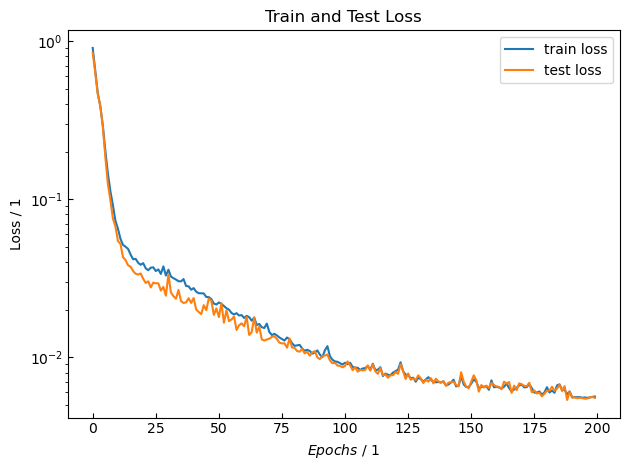

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.997096374204879 , R^2(NH3) = 0.9916798396273859
Test Dataset: R^2(H2) = 0.9964312481350012 , R^2(NH3) = 0.9920134619657912
Max Error Training: |x_H2 - x_H2,pred| = 0.0603488084792837 , |x_NH3 - x_NH3,pred| = 0.04084061882725007
Max Error Test: |x_H2 - x_H2,pred| = 0.0360640914809322 , |x_NH3 - x_NH3,pred| = 0.038050221931989064


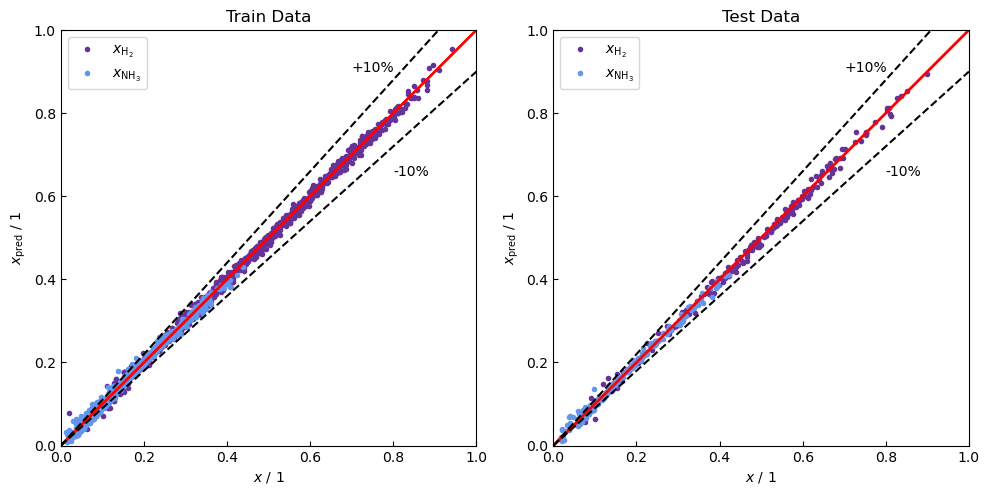

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

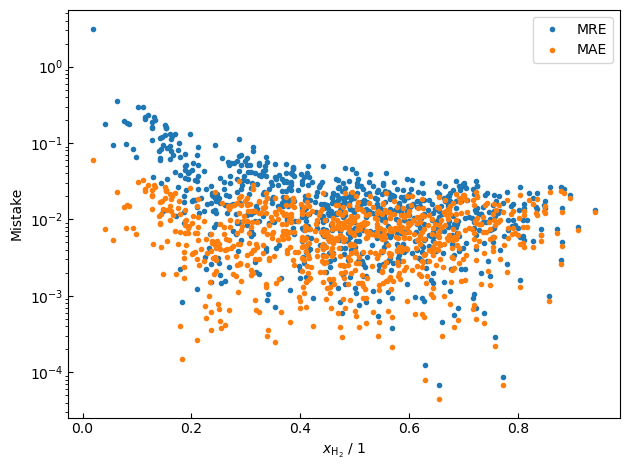

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

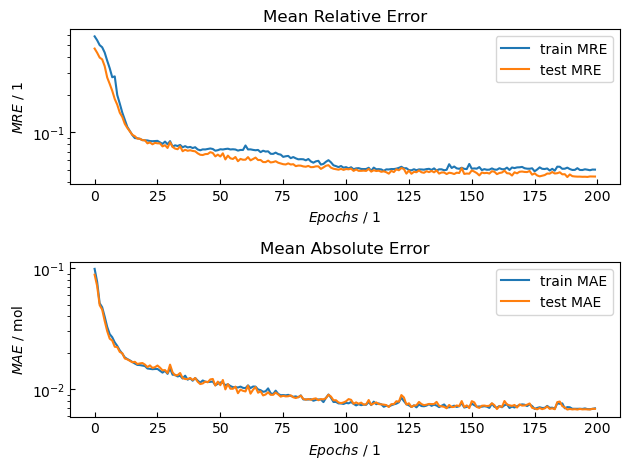

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

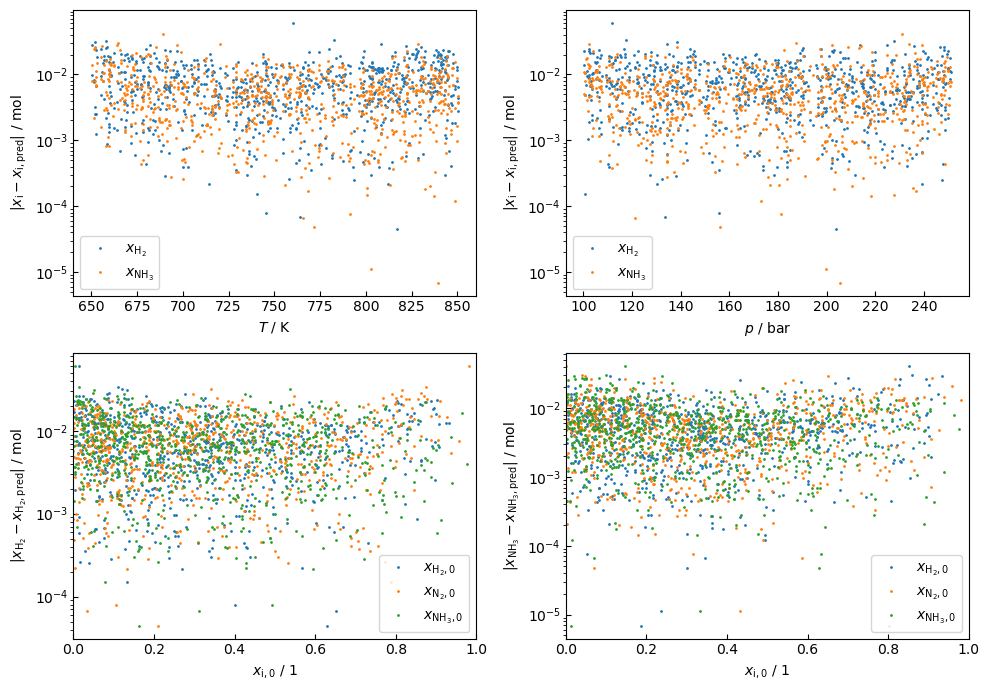

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

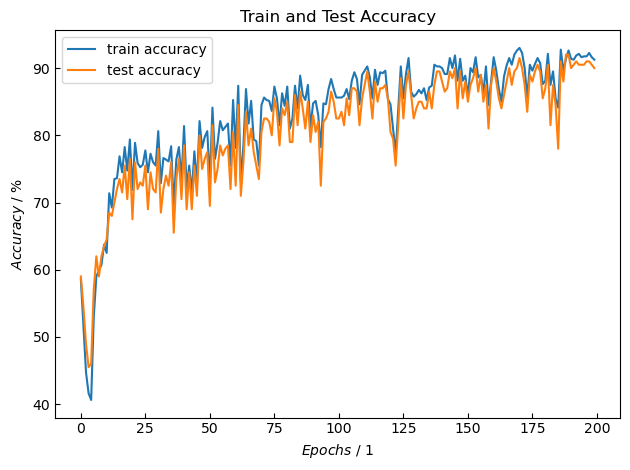

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.0 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.2235e+00, -1.5552e+00, -4.6707e-01, -1.5489e-01,  6.1668e-01],
        [-1.6272e+00,  2.8952e-01,  4.7627e-01, -1.2940e+00,  8.5516e-01],
        [-1.1914e+00,  1.3011e+00,  1.3677e+00, -1.1033e+00, -2.1461e-01],
        [-1.3038e+00, -1.5498e+00, -1.2927e+00, -6.4447e-01,  1.9273e+00],
        [-1.4430e+00, -1.8537e-02,  6.5650e-04, -3.0953e-01,  3.1572e-01],
        [-1.4109e+00,  1.2076e+00,  1.6388e+00, -8.8583e-01, -7.0292e-01],
        [-1.1012e-01, -1.0523e+00,  8.4818e-01, -5.1372e-01, -3.0734e-01],
        [-6.5761e-01, -1.5771e+00,  1.5039e+00, -3.1490e-01, -1.1540e+00],
        [ 1.4172e-01,  2.2994e-01,  1.0731e+00, -7.9201e-01, -2.4361e-01],
        [-4.5180e-01, -4.8805e-01, -1.0395e+00, -1.4504e-01,  1.1683e+00],
        [ 1.1604e+00, -3.9216e-01,  2.0512e+00, -7.9406e-01, -1.2014e+00],
        [-1.2011e+00,  6.9819e-01,  6.7602e-01,  6.2887e-01, -1.3062e+00],
        [ 1.0957e+00, -2.0430e-01, -1.0023e+00, -1.5229e-01,  1.1393e+00],
        [ 1.0499e+00, -8.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.2533,  0.1111,  0.4304, -0.5440,  0.2306],
         [-0.2705,  0.1136,  0.6939, -1.0753,  0.0364],
         [ 0.2353, -0.1130,  0.5164, -0.5530,  0.2790],
         [-0.6799,  0.2044, -0.1269, -0.1232, -0.0891],
         [-0.0929,  0.0265, -0.2960,  0.5101, -0.4487]], requires_grad=True),
 Parameter containing:
 tensor([ 0.9373, -2.3334,  0.4780,  0.1104, -0.3251], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0907,  0.8915,  0.8694, -0.3820, -0.8727],
         [ 1.0277, -1.5535, -0.9750,  1.0080, -0.6250]], requires_grad=True),
 Parameter containing:
 tensor([-0.3820, -0.5609], requires_grad=True)]

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0968, 0.3775, 0.6896, 0.6796, 0.4941],
        [0.1424, 0.5730, 0.7799, 0.5242, 0.4579]])
tensor([[ 0.1787, -0.0401],
        [ 0.2825,  0.0327]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-1.5917e+00,  8.4825e-01,  4.9244e-01,  2.6210e-01, -7.5116e-01],
        [ 1.4926e+00, -6.4122e-01, -3.3851e-01, -1.5372e-01,  4.8932e-01],
        [ 8.1819e-01, -1.5925e+00, -3.1246e-02,  9.4625e-01, -9.3647e-01],
        [ 4.0981e-01,  1.6669e+00, -1.3793e+00,  1.9584e+00, -6.4803e-01],
        [-1.4235e+00,  5.8443e-01, -2.2827e-01,  4.0609e-01, -1.9104e-01],
        [-1.0849e+00, -1.4037e+00,  2.2055e-01,  4.6251e-02, -2.6372e-01],
        [ 9.9650e-01,  6.9499e-01,  1.2499e+00, -1.3299e+00,  1.3262e-01],
        [ 1.1368e+00,  7.1636e-01, -1.3729e+00, -1.0466e+00,  2.4171e+00],
        [ 1.2618e+00, -7.6549e-01, -9.3106e-02,  4.3914e-01, -3.5746e-01],
        [-6.5081e-01,  1.3536e+00,  2.1032e+00, -1.2638e+00, -7.7232e-01],
        [ 4.4816e-01,  8.9056e-01,  8.7546e-01,  8.9958e-02, -9.5111e-01],
        [-1.3401e+00,  3.5059e-01, -4.8929e-01,  3.8394e-01,  8.7774e-02],
        [-4.0356e-01, -1.0010e+00, -9.4712e-01,  1.3230e+00, -4.2268e-01],
        [ 8.2184e-01, -5.

#### Histogramme Verteilung von $xi$ und $x{_i}$

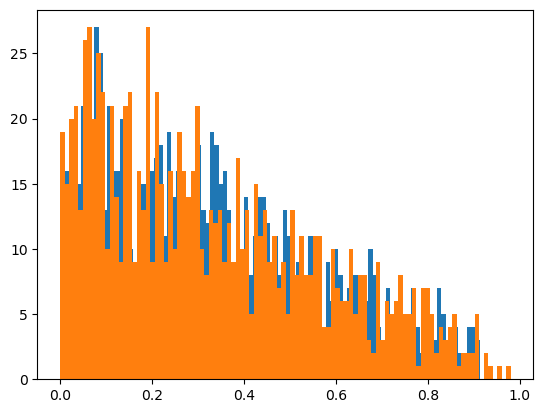

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_037.pth')
# np.savez('data/models/params_005_037.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)